# Оценка поведения пользователей мобильного приложения 

**Цель проекта**: оценить конверсию пользователей мобильного приложения в покупателей 

**Задачи проекта**:
1. Оценить поведение пользователей, выявить критические с точки зрения конверсии этапы
2. Оценить результаты эксперимента
3. Подготовить рекомендации по итогам оценки

## Исходные данные

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st

In [2]:
#Изучим имеющиеся данные
data = pd.read_csv('C:/Users/dobro/Downloads/logs_exp.csv', sep='\t')
display(data.head())
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В составе данных представлены: названия событий, ID устройств пользователей, которым соответствуют события, время совершения события, номер эксперимента.
Всего 244126 записей. Явные пропуски отсутствуют.


## Подготовка данных

In [3]:
# Переименуем наименования столбцов для дальнейшей работы.
data = data.rename(
    columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id', 'EventTimestamp': 'event_timestamp', 'ExpId':'exp_id'}
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id        244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
#Проверим данные на наличие пропусков
print('Пропущенных значений:')
print(data.isna().sum())

Пропущенных значений:
event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64


Пропущенные значения отсутствуют.

In [5]:
#Проверим данные на наличие полных дубликатов
print('Дублирующих значений:', len(data) - len(data.drop_duplicates()))
print('Дублирующие значения в % от массива:', round((len(data) - len(data.drop_duplicates()))*100.0/len(data),2))

Дублирующих значений: 413
Дублирующие значения в % от массива: 0.17


Выявлено 413 дублирующих записей, что составляет 0,17% от массива данных. Для обеспечения корректного анализа удалим дубликаты. 

In [35]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            243713 non-null  int64         
 1   event_name       243713 non-null  object        
 2   device_id        243713 non-null  int64         
 3   event_timestamp  243713 non-null  datetime64[ns]
 4   exp_id           243713 non-null  int64         
 5   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Данные о дате и времени события сохранены как целое число. Переведем их в формат даты из формата Unix.

In [7]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'],unit='s')
display(data.head())
data.info()

,index,event_name,device_id,event_timestamp,exp_id
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            243713 non-null  int64         
 1   event_name       243713 non-null  object        
 2   device_id        243713 non-null  int64         
 3   event_timestamp  243713 non-null  datetime64[ns]
 4   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


Столбец event_timestamp преобразован в столбец даты и времени. Создадим отдельный столбец дат.

In [8]:
data['event_date'] = pd.to_datetime(data['event_timestamp']).dt.date
display(data.head())

,index,event_name,device_id,event_timestamp,exp_id,event_date
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [9]:
#Рассмотрим типы событий, сохраненные в столбце event_name
print(data['event_name'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


В базе данных представлены 5 видов событий:
    - открытие основного экрана
    - обучение (инструкция)
    - открытие экрана с предложениями
    - открытие экрана с заказом ("корзины")
    - открытие экрана с успешной оплатой.
События не дублируются.

In [10]:
# Проверим корректность заполнения столбца по группам тестирования
print(data['exp_id'].unique())
print('Всего пользователей (по устройствам)', len(data['device_id'].unique()))

gr246 = data.loc[data['exp_id'] == 246,'device_id'].unique()
gr247 = data.loc[data['exp_id'] == 247,'device_id'].unique()
gr248 = data.loc[data['exp_id'] == 248,'device_id'].unique()
print('Пользователей группы 246', len(gr246))
print('Пользователей группы 247', len(gr247))
print('Пользователей группы 248', len(gr248))

[246 248 247]
Всего пользователей (по устройствам) 7551
Пользователей группы 246 2489
Пользователей группы 247 2520
Пользователей группы 248 2542


Все пользователи распределены на 3 экспериментальные группы (246, 247 и 248). Размер групп примерно равен.

In [36]:
# Проверим отсутствие одних и тех же пользователей в нескольких группах одновременно

print('Случаев одних и тех же пользователей в разных экспериментальных группах:', (
data
    .groupby('device_id')
    .agg({'exp_id' : 'nunique'})
    .query('exp_id>1')
))

Случаев одних и тех же пользователей в разных экспериментальных группах: Empty DataFrame
Columns: [exp_id]
Index: []


Случаи учета одних и тех же пользователей (устройств) в разных экспериментальных группах не выявлены. Это позволяет перейти к анализу данных.

**Промежуточный вывод** 

В рамках предварительной обработки данных была проведена проверка исходного массива на предмет пропусков (не выявлены) и дублирования. Дублирующие строки (413 записей или 0,17% от всего массива) удалены. Данные о времени событий переведены из формата Unix в формат даты и времени; массив дополнен отдельным столбцом, содержащим дату события (без времени). Проведена проверка данных на предмет полноты распределения пользователей* по экспериментальным группам и отсутствие фактов включения одних и тех же пользователей* в разные группы экспериментов. Такие случаи не обнаружены.

*Количество пользователей рассчитано по ID устройств. 

## Изучение и проверка данных

In [12]:
# Проанализируем общие показатели массива данных
print('Общее число событий в логе', len(data['event_name']))
print('Общее число пользователей (по устройствам)', len(data['device_id'].unique()))
print('Среднее число событий на одного пользователя', round(len(data['event_name'])/len(data['device_id'].unique()),2))

Общее число событий в логе 243713
Общее число пользователей (по устройствам) 7551
Среднее число событий на одного пользователя 32.28


In [13]:
# Проанализируем временной период, за который имеются данные
print('Минимальная дата', data['event_date'].min())
print('Максимальная дата', data['event_date'].max())

Минимальная дата 2019-07-25
Максимальная дата 2019-08-07


Данные охватывают период с 25 июля по 7 августа 2019 г.

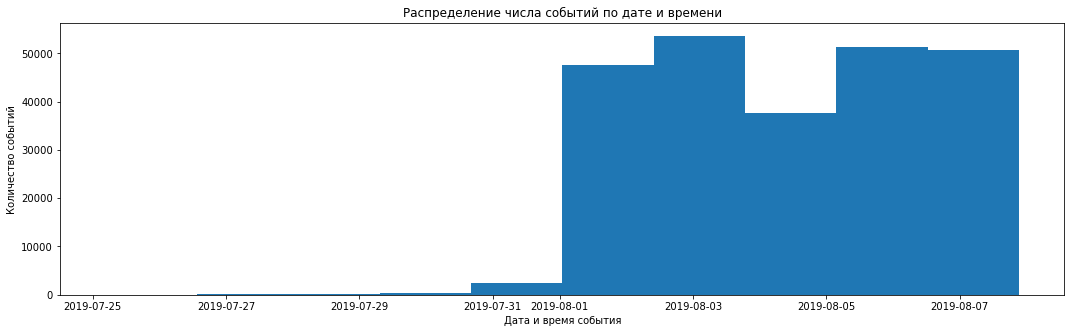

In [14]:
# Построим гистограмму по датам
plt.figure(figsize=(18, 5))  

# Строим график выручки группы А
plt.hist(data['event_timestamp'])

plt.title('Распределение числа событий по дате и времени')  
plt.xlabel('Дата и время события')
plt.ylabel('Количество событий')
plt.show()

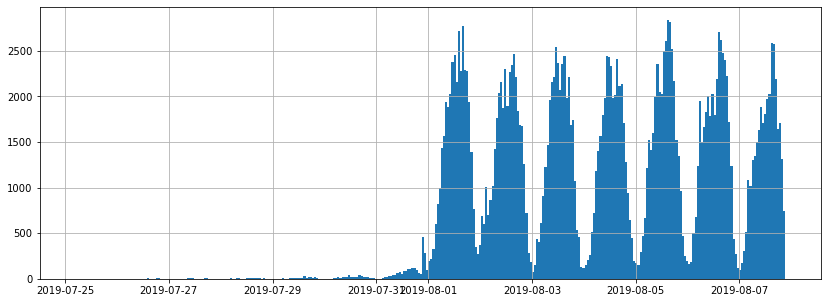

In [15]:
# код ревьюера
data['event_timestamp'].hist(bins=14*24, figsize=(14, 5));   

Как следует из графика, события распределены крайне неравномерны: за июль почти нет данных. Основная часть событий в логе характеризует данные после 1 августа. Для корректного анализа исключим из лога данные до 1 августа.

In [16]:
#Исключим из массива события, произошедшие до 2 августа
data['event_date'] = pd.to_datetime(data['event_date'])  
shdata = data.loc[data['event_date'] >='2019-08-01']
display(shdata.head())
print('Количество событий в новом логе', len(shdata))
print('Удалено событий за период 25.07.19-01.08.19', len(data)-len(shdata))
print('Доля удаленных событий в общем числе событий,%', round((len(data) - len(shdata))*100.0/len(data),2))

,index,event_name,device_id,event_timestamp,exp_id,event_date
2826,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


Количество событий в новом логе 240887
Удалено событий за период 25.07.19-01.08.19 2826
Доля удаленных событий в общем числе событий,% 1.16


Итак, после удаления событий, произошедших в те дни, по которым данные, очевидно, неполные, для анализа остались 240,9 тыс. событий или 98,8% от общего числа событий в логе.
Проверим, что при удалении событий сохранились данные о пользователях всех трех групп.

In [17]:
#Рассмотрим данные после исключения дней с неполными данными
print('Всего пользователей (по устройствам)', len(shdata['device_id'].unique()))

print('Исключено пользователей при удалении данных', len(data['device_id'].unique())-len(shdata['device_id'].unique()))

print('Доля исключенных пользователей в общем числе', 
     round((len(data['device_id'].unique())-len(shdata['device_id'].unique()))*100.0
      /len(data['device_id'].unique()),2))

print('Событий в среднем на одного пользователя', round(len(shdata['event_name'])/len(shdata['device_id'].unique()),2))

gr246 = shdata.loc[shdata['exp_id'] == 246,'device_id'].unique()
gr247 = shdata.loc[shdata['exp_id'] == 247,'device_id'].unique()
gr248 = shdata.loc[shdata['exp_id'] == 248,'device_id'].unique()

print('Пользователей группы 246', len(gr246))
print('Пользователей группы 247', len(gr247))
print('Пользователей группы 248', len(gr248))

Всего пользователей (по устройствам) 7534
Исключено пользователей при удалении данных 17
Доля исключенных пользователей в общем числе 0.23
Событий в среднем на одного пользователя 31.97
Пользователей группы 246 2484
Пользователей группы 247 2513
Пользователей группы 248 2537


**Промежуточный вывод**

В массиве данных представлены сведения о событиях, совершенных пользователями мобильного приложения с 25.07.2019 по 08.08.2019. Проведенный анализ показал, что количество событий распределено по дням крайне неравномерно, что позволяет предположить, что данные за 25.07-08.01 неполные. 

Для исключения влияния неполных данных на результаты анализа, информация за 25.07 - 31.07 была исключена из лога. Это привело к исключению 1,16% событий и 0,23% пользователей. Общее число событий, использованных для дальнейшего анализа, составило 240887. Общее число пользователей - 7534. В рамках лога приведены данные по пользователям всех трех групп. В среднем на одного пользователя приходится 31,97 событий.

## Изучение воронки событий

In [18]:
#Рассмотрим, частоту событий в логе по их видам
shdata.groupby('event_name')['device_id'].count()


event_name
CartScreenAppear            42303
MainScreenAppear           117328
OffersScreenAppear          46333
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: device_id, dtype: int64

Чаще всего пользователи открывали основной экран приложения (117,3 тыс. раз). Существенно реже  - страницу с предложениями о продаже (46,3 тыс. раз). Несколько реже происходили события, связанные с отображением корзины и реже всего - с проведением успешного платежа.

Доля событий, связанных с использованием инструкций, невелика и составляет менее 0,5% в общем числе событий.

In [19]:
#Рассмотрим данные о событиях в разрезе пользователей
events_by_users = shdata.pivot_table(
    index='event_name',values='device_id',aggfunc='nunique'
    ).sort_values(by='device_id',ascending=False)

events_by_users.columns = ['users_no']

events_by_users['perc_of_total'] = round(events_by_users['users_no']*100.0/len(shdata['device_id'].unique()),2)

display(events_by_users)

,users_no,perc_of_total
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Как следует из результатов расчета, 98,47% пользователей открывали основной экран приложения. 60,96% пользователей открывали страницы со специальными предложениями. Почти половина пользователей (49,56%) открывала корзину (т.е. начинала формировать заказ), а успешно оплатили заказ 46,97% пользователей. Инструкциями воспользовались 11,15% пользователей мобильного приложения.

Исходя из данных о событиях в разрезе пользователей можно сформировать следующую воронку событий:

1. Открытие основной страницы приложения
2. Открытие страницы с предлагаемыми товарами
3. Открытие корзины
4. Отображение страницы с успешным платежом

Открытие страницы с инструкциями (Tutorial) не является обязательным и не учитывается в воронке событий.

In [20]:
#Рассчитаем конверсию пользователей по каждому этапу воронки

events_by_users['perc_stage'] = round(events_by_users['users_no']*100.0/events_by_users['users_no'].shift(1),2) 
events_by_users['total_sucess'] = round(events_by_users['users_no']*100.0/events_by_users['users_no'].shift(3),2) 
display(events_by_users)


,users_no,perc_of_total,perc_stage,total_sucess
event_name,,,,
MainScreenAppear,7419,98.47,NaN,NaN
OffersScreenAppear,4593,60.96,61.91,NaN
CartScreenAppear,3734,49.56,81.30,NaN
PaymentScreenSuccessful,3539,46.97,94.78,47.70
Tutorial,840,11.15,23.74,18.29


**Расчеты конверсии по этапам воронки событий** показывают, что:
- 61,91% пользователей, открывших главную страницу, дошли до страниц с предложениями товаров;
- 81,30% пользователей, открывших страницу с предложениями товаров, открыли корзину;
- 94,78% пользователей, открывших корзину, успешно ее оплатили.
47,7% пользователей, открывших приложение, успешно оплатили товары.

**Промежуточный вывод**

В целом приложение достаточно успешно: почти половина пользователей, открывших приложение (47,7%), дошло до оплаты.

Однако расчет конверсии по этапам воронки событий показывает, что наибольшее число пользователей (38,8%), открывших приложение, теряется на этапе между открытием основного экрана и переходом на страницы с конкретными предложениями товаров. Можно предположить, что навигация на главной странице не очень удобна.

## Анализ результатов эксперимента

In [21]:
# разделим пользователей по группам и событиям
events_grouped = shdata.pivot_table(
                 index='event_name', columns='exp_id', 
                 values='device_id', aggfunc='nunique', margins=True).reset_index().sort_values(
                 'All', ascending=False).reset_index(drop=True)
    
display(events_grouped)

exp_id,event_name,246,247,248,All
0,All,2484,2513,2537,7534
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
3,CartScreenAppear,1266,1238,1230,3734
4,PaymentScreenSuccessful,1200,1158,1181,3539
5,Tutorial,278,283,279,840


Общее число пользователей в группе 246 составило 2393, в группе 247 - 2434, а в группе 248 - 2459.
В соответствии с исходными данными, группы 246 и 247 - контрольные. Для корректной интерпретации результатов эксперимента необходимо проверить разницу между выборками 246 и 247.

Для проверки статистического равенства выборок 246 и 247 проведем z-тест по наиболее часто встречающемуся событию (открытию главного экрана).
**Нулевая гипотеза:** различия в доле успешных открытий главного экрана в выборках отсутствуют.
**Альтернативная гипотеза:** имеются различия в доле успешных открытий главного экрана в выборках.

In [22]:
#Рассчитаем доли успешного открытия главного экрана в этих двух выборках
print('Доля открытий главного экрана в группе 246', round(events_grouped.loc[1,246]*100/events_grouped.loc[0,246],2))
print('Доля открытий главного экрана в группе 247', round(events_grouped.loc[1,247]*100/events_grouped.loc[0,247],2))

Доля открытий главного экрана в группе 246 98.63
Доля открытий главного экрана в группе 247 98.53


In [23]:
# Проверяем, находят ли статистические критерии разницу между выборками 246 и 247
alpha = .05 # критический уровень статистической значимости

successes = np.array([events_grouped.loc[1,246], events_grouped.loc[1,247]]) #успехом считаем открытие главного экрана (самое популярное событие)
trials = np.array([events_grouped.loc[0,246], events_grouped.loc[0,247]]) #попыткой считаем общее число пользователей группы

# пропорция успехов в первой группе:
p246 = successes[0]/trials[0]
# пропорция успехов во второй группе:
p247 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p246 - p247

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные проверки целесообразно провести и для других событий. Для этого напишем общую функцию проверки равенства долей percentage_equality.

In [24]:
def percentage_equality(successes,trials,alpha):
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    if p_value < alpha:
        result = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'
    else:
        result = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    return 'p-значение',round(p_value,3), result

In [25]:
# Рассчитаем доли пользователей, выполнивших те или иные события в каждой из групп

events_grouped['share_246'] = round(events_grouped[246]*100.0/events_grouped[246].max(),2)
events_grouped['share_247'] = round(events_grouped[247]*100.0/events_grouped[247].max(),2)
events_grouped['share_248'] = round(events_grouped[248]*100.0/events_grouped[248].max(),2)

display(events_grouped)

exp_id,event_name,246,247,248,All,share_246,share_247,share_248
0,All,2484,2513,2537,7534,100.00,100.00,100.00
1,MainScreenAppear,2450,2476,2493,7419,98.63,98.53,98.27
2,OffersScreenAppear,1542,1520,1531,4593,62.08,60.49,60.35
3,CartScreenAppear,1266,1238,1230,3734,50.97,49.26,48.48
4,PaymentScreenSuccessful,1200,1158,1181,3539,48.31,46.08,46.55
5,Tutorial,278,283,279,840,11.19,11.26,11.00


In [26]:
#Сопоставим доли совершивших остальные типы событий по двум контрольным группам

alpha = 0.05

print('Проверка по доле открывших предложения с товарами')
print(percentage_equality(np.array([events_grouped.loc[2,246],events_grouped.loc[2,247]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,247]]),alpha))

print('Проверка по доле открывших страницу с корзиной')
print(percentage_equality(np.array([events_grouped.loc[3,246],events_grouped.loc[3,247]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,247]]),alpha))

print('Проверка по доле совершивших успешную покупку')
print(percentage_equality(np.array([events_grouped.loc[4,246],events_grouped.loc[4,247]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,247]]),alpha))

print('Проверка по доле открывших инструкции')
print(percentage_equality(np.array([events_grouped.loc[5,246],events_grouped.loc[5,247]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,247]]),alpha))

Проверка по доле открывших предложения с товарами
('p-значение', 0.248, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших страницу с корзиной
('p-значение', 0.229, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле совершивших успешную покупку
('p-значение', 0.115, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших инструкции
('p-значение', 0.938, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Результаты проверки показывают, что ни по одному показателю нет оснований считать доли разными в выборках 246 и 247. 

**Таким образом, статистические тесты не выявили значимых существенных различий между двумя контрольными группами пользователей. Это позволяет сопоставить результаты экспериментальной группы 248 с результатами контрольных групп 246 и 247.**

In [27]:
#Сопоставим результаты экспериментальной группы 248 с данными контрольной группы 246

print('Проверка по доле открывших главный экран')
print(percentage_equality(np.array([events_grouped.loc[1,246],events_grouped.loc[1,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших предложения с товарами')
print(percentage_equality(np.array([events_grouped.loc[2,246],events_grouped.loc[2,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших страницу с корзиной')
print(percentage_equality(np.array([events_grouped.loc[3,246],events_grouped.loc[3,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле совершивших успешную покупку')
print(percentage_equality(np.array([events_grouped.loc[4,246],events_grouped.loc[4,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))


Проверка по доле открывших главный экран
('p-значение', 0.295, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших предложения с товарами
('p-значение', 0.208, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших страницу с корзиной
('p-значение', 0.078, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле совершивших успешную покупку
('p-значение', 0.212, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Ни по одному из показателей не выявлено значимых различий между данными экспериментальной группы 248 и контрольной группы 246. 

In [28]:
#Сопоставим результаты экспериментальной группы 248 с данными контрольной группы 247

print('Проверка по доле открывших главный экран')
print(percentage_equality(np.array([events_grouped.loc[1,247],events_grouped.loc[1,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших предложения с товарами')
print(percentage_equality(np.array([events_grouped.loc[2,247],events_grouped.loc[2,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших страницу с корзиной')
print(percentage_equality(np.array([events_grouped.loc[3,247],events_grouped.loc[3,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле совершивших успешную покупку')
print(percentage_equality(np.array([events_grouped.loc[4,247],events_grouped.loc[4,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

Проверка по доле открывших главный экран
('p-значение', 0.459, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших предложения с товарами
('p-значение', 0.92, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших страницу с корзиной
('p-значение', 0.579, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле совершивших успешную покупку
('p-значение', 0.737, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Ни по одному из показателей не выявлено значимых различий между данными экспериментальной группы 248 и контрольной группы 247.

In [29]:
# Проведем сопоставление экспериментальной группы 248 с объединенной контрольной группой (246 и 247)

# Дополним таблицу events_grouped столбцом с объединенными данными
events_grouped['control'] = events_grouped[246] + events_grouped[247]

display(events_grouped)

exp_id,event_name,246,247,248,All,share_246,share_247,share_248,control
0,All,2484,2513,2537,7534,100.00,100.00,100.00,4997
1,MainScreenAppear,2450,2476,2493,7419,98.63,98.53,98.27,4926
2,OffersScreenAppear,1542,1520,1531,4593,62.08,60.49,60.35,3062
3,CartScreenAppear,1266,1238,1230,3734,50.97,49.26,48.48,2504
4,PaymentScreenSuccessful,1200,1158,1181,3539,48.31,46.08,46.55,2358
5,Tutorial,278,283,279,840,11.19,11.26,11.00,561


In [30]:
#Сопоставим результаты экспериментальной группы 248 с данными объединенной контрольной группы

print('Проверка по доле открывших главный экран')
print(percentage_equality(np.array([events_grouped.loc[1,'control'],events_grouped.loc[1,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших предложения с товарами')
print(percentage_equality(np.array([events_grouped.loc[2,'control'],events_grouped.loc[2,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших страницу с корзиной')
print(percentage_equality(np.array([events_grouped.loc[3,'control'],events_grouped.loc[3,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле совершивших успешную покупку')
print(percentage_equality(np.array([events_grouped.loc[4,'control'],events_grouped.loc[4,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

Проверка по доле открывших главный экран
('p-значение', 0.294, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших предложения с товарами
('p-значение', 0.434, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших страницу с корзиной
('p-значение', 0.182, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле совершивших успешную покупку
('p-значение', 0.6, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Ни по одному из показателей не выявлено значимых различий между данными экспериментальной группы 248 и объединенной контрольной группы.

**Промежуточный вывод** 

Изменение шрифтов в приложении не привело к повышению конверсии пользователей. Различий доле пользователей, достигших тех или иных событий в воронке событий, между экспериментальной группой и контрольными группами (а также объединенной контрольной группой) не выявлено.
**На основе проведенного анализа переход к новым шрифтам в приложении нецелесообразен**.

Анализ результатов эксперимента предполагал многократное сопоставление данных между тремя различными группами. Всего экспериментальную группу мы сопоставляли с контрольными в разных комбинациях 12 раз. Такое многократное сопоставление может приводить к риску появления ошибок первого рода - получения ложноположительных результатов в случаях, когда на самом деле различия отсутствуют.

Для снижения указанного риска целесообразно применять поправку Бонферрони (т.е. скорректировать уровень значимости альфа, разделив его на число проведенных тестов).

In [31]:
#Рассчитаем скорректированное значение альфа
alphab = 0.05/12
print('Скорректированный уровень значимости', alphab)

Скорректированный уровень значимости 0.004166666666666667


In [32]:
#Сопоставим результаты экспериментальной группы 248 с данными контрольной группы 246

alpha = alphab
print('Проверка по доле открывших главный экран')
print(percentage_equality(np.array([events_grouped.loc[1,246],events_grouped.loc[1,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших предложения с товарами')
print(percentage_equality(np.array([events_grouped.loc[2,246],events_grouped.loc[2,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших страницу с корзиной')
print(percentage_equality(np.array([events_grouped.loc[3,246],events_grouped.loc[3,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле совершивших успешную покупку')
print(percentage_equality(np.array([events_grouped.loc[4,246],events_grouped.loc[4,248]]),
                          np.array([events_grouped.loc[0,246],events_grouped.loc[0,248]]),alpha))


Проверка по доле открывших главный экран
('p-значение', 0.295, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших предложения с товарами
('p-значение', 0.208, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших страницу с корзиной
('p-значение', 0.078, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле совершивших успешную покупку
('p-значение', 0.212, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


In [33]:
#Сопоставим данные экспериментальной группы 248 с данными контрольной группы 247

print('Проверка по доле открывших главный экран')
print(percentage_equality(np.array([events_grouped.loc[1,247],events_grouped.loc[1,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших предложения с товарами')
print(percentage_equality(np.array([events_grouped.loc[2,247],events_grouped.loc[2,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших страницу с корзиной')
print(percentage_equality(np.array([events_grouped.loc[3,247],events_grouped.loc[3,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле совершивших успешную покупку')
print(percentage_equality(np.array([events_grouped.loc[4,247],events_grouped.loc[4,248]]),
                          np.array([events_grouped.loc[0,247],events_grouped.loc[0,248]]),alpha))

Проверка по доле открывших главный экран
('p-значение', 0.459, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших предложения с товарами
('p-значение', 0.92, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших страницу с корзиной
('p-значение', 0.579, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле совершивших успешную покупку
('p-значение', 0.737, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


In [34]:
#Сопоставим результаты экспериментальной группы 248 с данными объединенной контрольной группы

print('Проверка по доле открывших главный экран')
print(percentage_equality(np.array([events_grouped.loc[1,'control'],events_grouped.loc[1,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших предложения с товарами')
print(percentage_equality(np.array([events_grouped.loc[2,'control'],events_grouped.loc[2,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле открывших страницу с корзиной')
print(percentage_equality(np.array([events_grouped.loc[3,'control'],events_grouped.loc[3,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

print('Проверка по доле совершивших успешную покупку')
print(percentage_equality(np.array([events_grouped.loc[4,'control'],events_grouped.loc[4,248]]),
                          np.array([events_grouped.loc[0,'control'],events_grouped.loc[0,248]]),alpha))

Проверка по доле открывших главный экран
('p-значение', 0.294, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших предложения с товарами
('p-значение', 0.434, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле открывших страницу с корзиной
('p-значение', 0.182, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
Проверка по доле совершивших успешную покупку
('p-значение', 0.6, 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


**Промежуточный вывод**

Изменение шрифтов в приложении не привело к повышению конверсии пользователей. Различий доле пользователей, достигших тех или иных событий в воронке событий, между экспериментальной группой и контрольными группами (а также объединенной контрольной группой) не выявлено. На основе проведенного анализа переход к новым шрифтам в приложении нецелесообразен.


## Общий вывод

Ни по одному из показателей не выявлено значимых различий между данными экспериментальной группы 248 и контрольной группы 247.

**Цель проекта** заключалась в оценке конверсии пользователей мобильного приложения в покупателей 


**Задачи проекта**:
1. Оценить поведение пользователей, выявить критические с точки зрения конверсии этапы
2. Оценить результаты эксперимента
3. Подготовить рекомендации по итогам оценки

В качестве исходных данных представлен массив, содержащий названия событий, ID устройств пользователей, которым соответствуют события, время совершения события, номер эксперимента. Исходные данные позволяют провести анализ в разрезе пользователей на основании ID устройств (т.е. в качестве одного пользователя принимается пользователь одного устройства).
Всего 244126 записей. Явные пропуски отсутствуют.

В рамках предварительной обработки данных была проведена проверка исходного массива на предмет пропусков (не выявлены) и дублирования. Дублирующие строки (413 записей или 0,17% от всего массива) удалены. Данные о времени событий переведены из формата Unix в формат даты и времени; массив дополнен отдельным столбцом, содержащим дату события (без времени). Проведена проверка данных на предмет полноты распределения пользователей по экспериментальным группам и отсутствие фактов включения одних и тех же пользователей в разные группы экспериментов. Такие случаи не обнаружены.

В массиве данных представлены сведения о событиях, совершенных пользователями мобильного приложения с 25.07.2019 по 08.08.2019. Проведенный анализ показал, что количество событий распределено по дням крайне неравномерно, что позволяет предположить, что данные за 25.07-31.07 неполные. 

Для исключения влияния неполных данных на результаты анализа, информация за 25.07 - 31.07 была исключена из лога. Это привело к исключению 1,16% событий и 0,23% пользователей. Общее число событий, использованных для дальнейшего анализа, составило 240887. Общее число пользователей - 7534. В рамках лога приведены данные по пользователям всех трех групп. В среднем на одного пользователя приходится 31,97 событий.

Как следует из результатов расчета, 98,47% пользователей открывали основной экран приложения. 60,96% пользователей открывали страницы со специальными предложениями. Почти половина пользователей (49,56%) открывала корзину (т.е. начинала формировать заказ), а успешно оплатили заказ 46,97% пользователей. Инструкциями воспользовались 11,15% пользователей мобильного приложения.

Исходя из данных о событиях в разрезе пользователей можно сформировать следующую воронку событий:

1. Открытие основной страницы приложения
2. Открытие страницы с предлагаемыми товарами
3. Открытие корзины
4. Отображение страницы с успешным платежом


Анализ воронки событий показывает следующие результаты:
  
- 61,91% пользователей, открывших главную страницу, дошли до страниц с предложениями товаров;
- 81,30% пользователей, открывших страницу с предложениями товаров, открыли корзину;
- 94,78% пользователей, открывших корзину, успешно ее оплатили.
- 47,7% пользователей, открывших приложение, успешно оплатили товары.

Расчет конверсии по этапам воронки событий показывает, что наибольшее число пользователей (38,8%), открывших приложение, теряется на этапе между открытием основного экрана и переходом на страницы с конкретными предложениями товаров. Можно предположить, что навигация на главной странице не очень удобна.

Для анализа результата эксперимента с внедрением новых шрифтов использовался статистический z-тест, позволяющий подтвердить либо отвергнуть гипотезу о равенстве долей в выборках.

В массиве изначально выделены 2 контрольные группы 246 и 247. Результаты проверки показывают, что по ни по одному из 5 показателей различий между группами не обнаружено.

**Таким образом, статистические тесты не выявили значимых существенных различий между двумя контрольными группами пользователей. Это позволяет сопоставить результаты экспериментальной группы 248 с результатами контрольных групп 246 и 247.**

В рамках анализа доля пользователей, достигших каждого этапа воронки событий в экспериментальной группе 248, была сопоставлена с долей пользователей, достигших аналогичного этапа в контрольных группах 246 и 247.

По результатам статистического теста значимых различий между выборками 247 и 248, а также между выборками 246 и 248 не выявлено.

Отметим, что для анализа был выбран уровень статистической значимости, равный 0,05%. С учетом многократного сопоставления групп между собой для оценки AB-теста целесообразно применять поправку Бонферрони, что снизит уровень статистической значимости до 0,004%.


Изменение шрифтов в приложении не привело к повышению конверсии пользователей. 

**На основе проведенного анализа не рекомендуется внедрять новые шрифты для всех пользователей приложения**.